Log Analyzer
------------

In [87]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re
import os
from datetime import datetime
from tqdm import tqdm

## Variables

In [134]:
LOG_PATH = "../../../log/DCDeepModelV4.0-reda-renault-speed_accel_gyro-batch128-1620155768.1678748.debug.log"
MAX_NODES_PER_TURN = 112

## Parser

In [89]:
class LogParser:
    def __init__(self, log_path):
        # Regex
        self.arg_regex = r"\[([^\[=\"'\]]+)\]"
        self.kwarg_regex = r"\[([^\[=\"'\]]+)=\"([^\"]*)\"\]"

        self.data = self.load(log_path)
    
    def load(self, log_path):
        rows = []
        columns = ["datetime", "level", "position", "args", "kwargs"]
        with open(LOG_PATH, "r") as f:
            for line in tqdm(f):
                # Split "DATE | LEVEL | FILE:FUNC:LINE - MESSAGE" with "|" separator
                splited_line = line.split("|")

                # We remove space and `\n` before and after the string in each cell
                cleaned_splited_line = [s.strip() for s in splited_line]

                # Split "FILE:FUNC:LINE - MESSAGE" with " - " separator
                position_and_message = cleaned_splited_line.pop(2)
                # So, we have : `[ "DATE", "LEVEL" ]`
                
                position, message = position_and_message.split(" - ")

                # Append `position` into `cleaned_splited_line`
                # To get this : `[ "DATE", "LEVEL", "FILE:FUNC:LINE" ]`
                cleaned_splited_line.append(position)

                # Parse args : "[TAG1][TAG2]" ==> `[ "TAG1", "TAG2" ]`
                args = re.findall(self.arg_regex, message)
                cleaned_splited_line.append(args)

                # Parse kwargs : '[NAME1="VAL1"][NAME2="VAL2"]' ==> `{ NAME1 :"VAL1", NAME2 :"VAL2" }`
                kwarg = dict()
                for match in re.finditer(self.kwarg_regex, message, re.S):
                    kwarg[match.group(1)] = match.group(2)
                cleaned_splited_line.append(kwarg)

                rows.append(cleaned_splited_line)
        self.data = pd.DataFrame(rows, columns = columns)
        return self.data

In [90]:
lp = LogParser(LOG_PATH)
lp.data

131978it [00:01, 94705.26it/s]


datetime    level  \
0       2021-08-11 22:19:11.550     INFO   
1       2021-08-11 22:19:11.550     INFO   
2       2021-08-11 22:19:11.550     INFO   
3       2021-08-11 22:19:11.550     INFO   
4       2021-08-11 22:19:11.551     INFO   
...                         ...      ...   
131973  2021-08-12 00:08:42.205  SUCCESS   
131974  2021-08-12 00:08:42.205  WARNING   
131975  2021-08-12 00:08:42.208  SUCCESS   
131976  2021-08-12 00:08:42.208     INFO   
131977  2021-08-12 00:08:42.210     INFO   

                                                 position  \
0                                         __main__:run:79   
1                                         __main__:run:80   
2                                         __main__:run:81   
3                                         __main__:run:82   
4                                         __main__:run:83   
...                                                   ...   
131973  dcevaluator.communication.dc_client:each_turn:182   
131974  dcevaluator.evaluator.evaluator:check_limit_tu...   
131975  dcevaluator.evaluator.evaluator:end_evaluation...   
131976  dcevaluator.evaluator.evaluator:end_evaluation...   
131977           dcevaluator.evaluator.evaluator:stop:118   

                                 args  \
0       [Donkey Car Evaluator, BEGIN]   
1                                  []   
2                                  []   
3                                  []   
4                                  []   
...                               ...   
131973                     [NEW TURN]   
131974                        [LIMIT]   
131975              [EVALUATION, END]   
131976                      [SUMMARY]   
131977    [Donkey Car Evaluator, END]   

                                                   kwargs  
0                                                      {}  
1                          {'evaluation_name': 'No Name'}  
2                                   {'host': '127.0.0.1'}  
3                                        {'port': '9091'}  
4              {'evaluation_scene': 'roboracingleague_1'}  
...                                                   ...  
131973   {'turn': '10', 'deltatime': '646.6847207546234'}  
131974  {'message': 'Number of limit turns reached', '...  
131975                                    {'epoch': '10'}  
131976  {'epoch': '10', 'turn': '10', 'last_node': '0'...  
131977                                                 {}  

[131978 rows x 5 columns]

NOTE : Don't forget to clip the logs between the beginning and the end of the evaluator in case the logs of several evaluators are mixed

## Distance to center of the road

In [141]:
center = df[df.position == "dcevaluator.communication.dc_client:on_telemetry:119"]
center

datetime  level  \
22      2021-08-11 22:19:17.377  DEBUG   
23      2021-08-11 22:19:17.418  DEBUG   
24      2021-08-11 22:19:17.475  DEBUG   
25      2021-08-11 22:19:17.516  DEBUG   
26      2021-08-11 22:19:17.570  DEBUG   
...                         ...    ...   
131967  2021-08-12 00:08:42.003  DEBUG   
131968  2021-08-12 00:08:42.053  DEBUG   
131969  2021-08-12 00:08:42.104  DEBUG   
131970  2021-08-12 00:08:42.154  DEBUG   
131971  2021-08-12 00:08:42.204  DEBUG   

                                                 position args  \
22      dcevaluator.communication.dc_client:on_telemet...   []   
23      dcevaluator.communication.dc_client:on_telemet...   []   
24      dcevaluator.communication.dc_client:on_telemet...   []   
25      dcevaluator.communication.dc_client:on_telemet...   []   
26      dcevaluator.communication.dc_client:on_telemet...   []   
...                                                   ...  ...   
131967  dcevaluator.communication.dc_client:on_telemet...   []   
131968  dcevaluator.communication.dc_client:on_telemet...   []   
131969  dcevaluator.communication.dc_client:on_telemet...   []   
131970  dcevaluator.communication.dc_client:on_telemet...   []   
131971  dcevaluator.communication.dc_client:on_telemet...   []   

                                                   kwargs  
22      {'turn': '0', 'active_node': '112', 'last_node...  
23      {'turn': '0', 'active_node': '112', 'last_node...  
24      {'turn': '0', 'active_node': '112', 'last_node...  
25      {'turn': '0', 'active_node': '112', 'last_node...  
26      {'turn': '0', 'active_node': '112', 'last_node...  
...                                                   ...  
131967  {'turn': '9', 'active_node': '112', 'last_node...  
131968  {'turn': '9', 'active_node': '112', 'last_node...  
131969  {'turn': '9', 'active_node': '112', 'last_node...  
131970  {'turn': '9', 'active_node': '112', 'last_node...  
131971  {'turn': '9', 'active_node': '0', 'last_node':...  

[130400 rows x 5 columns]

In [142]:
df_center = pd.DataFrame(center.kwargs.to_list())
df_center

turn active_node last_node distance_center
0         0         112        -1       0.3282169
1         0         112       112       0.3282155
2         0         112       112       0.3282131
3         0         112       112       0.3282115
4         0         112       112       0.3282171
...     ...         ...       ...             ...
130395    9         112       112       0.7680664
130396    9         112       112       0.7131463
130397    9         112       112       0.6760775
130398    9         112       112       0.6206709
130399    9           0       112       0.5836462

[130400 rows x 4 columns]

In [146]:
df_distance_center = pd.to_numeric(df_center.distance_center, downcast="float")
df_distance_center.describe()

count    130400.000000
mean         -0.143128
std           0.816862
min          -3.539121
25%          -0.647392
50%          -0.270065
75%           0.302946
max           4.932717
Name: distance_center, dtype: float64

In [153]:
df_center.turn.to_list()[1333]

'0'

array([['0', '112', '-1', '0.3282169'],
       ['0', '112', '112', '0.3282155'],
       ['0', '112', '112', '0.3282131'],
       ...,
       ['9', '112', '112', '0.6760775'],
       ['9', '112', '112', '0.6206709'],
       ['9', '0', '112', '0.5836462']], dtype=object)

In [164]:
df_distance_center_group = pd.DataFrame(df_center.values, index=[df_center.turn.to_list(), df_center.active_node.to_list()], columns=df_center.columns)
df_distance_center_group

turn active_node last_node distance_center
0 112    0         112        -1       0.3282169
  112    0         112       112       0.3282155
  112    0         112       112       0.3282131
  112    0         112       112       0.3282115
  112    0         112       112       0.3282171
...    ...         ...       ...             ...
9 112    9         112       112       0.7680664
  112    9         112       112       0.7131463
  112    9         112       112       0.6760775
  112    9         112       112       0.6206709
  0      9           0       112       0.5836462

[130400 rows x 4 columns]

In [172]:
df_distance_center_group_value = df_distance_center_group.apply(lambda r: float(r.distance_center), axis=1)

In [177]:
df_dc_mean = df_distance_center_group_value.mean(axis=0, level=1)
df_dc_mean

/tmp/ipykernel_11291/1863137585.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_dc_mean = df_distance_center_group_value.mean(axis=0, level=1)


112    0.264794
0      0.129950
1     -0.502525
2      0.069583
3      0.049185
         ...   
107   -0.162452
108   -0.094518
109    0.853700
110    1.395733
111    0.762741
Length: 113, dtype: float64

Text(0, 0.5, 'Average distance of the car from the center of the road')

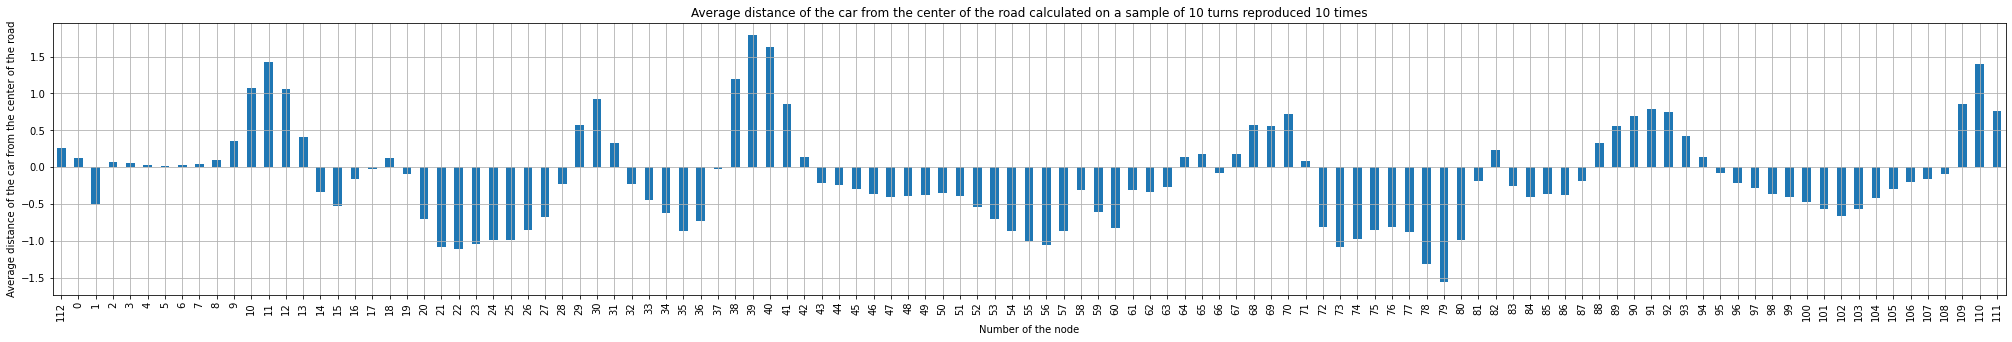

In [186]:
ax = df_dc_mean.plot.bar(figsize=(35,5), grid=True, title = "Average distance of the car from the center of the road calculated on a sample of 10 turns reproduced 10 times")
ax.set_xlabel("Number of the node")
ax.set_ylabel("Average distance of the car from the center of the road")

## Summary

In [116]:
summary = df[df.apply(lambda r: "SUMMARY" in r.args, axis = 1)]
summary

datetime level  \
13357   2021-08-11 22:30:16.382  INFO   
26531   2021-08-11 22:41:12.319  INFO   
39733   2021-08-11 22:52:09.568  INFO   
52870   2021-08-11 23:03:03.680  INFO   
66051   2021-08-11 23:13:59.928  INFO   
79221   2021-08-11 23:24:55.673  INFO   
92384   2021-08-11 23:35:51.018  INFO   
105599  2021-08-11 23:46:48.964  INFO   
118835  2021-08-11 23:57:47.957  INFO   
131976  2021-08-12 00:08:42.208  INFO   

                                                 position       args  \
13357   dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   
26531   dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   
39733   dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   
52870   dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   
66051   dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   
79221   dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   
92384   dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   
105599  dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   
118835  dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   
131976  dcevaluator.evaluator.evaluator:end_evaluation...  [SUMMARY]   

                                                   kwargs  
13357   {'epoch': '1', 'turn': '10', 'last_node': '0',...  
26531   {'epoch': '2', 'turn': '10', 'last_node': '0',...  
39733   {'epoch': '3', 'turn': '10', 'last_node': '0',...  
52870   {'epoch': '4', 'turn': '10', 'last_node': '0',...  
66051   {'epoch': '5', 'turn': '10', 'last_node': '0',...  
79221   {'epoch': '6', 'turn': '10', 'last_node': '0',...  
92384   {'epoch': '7', 'turn': '10', 'last_node': '0',...  
105599  {'epoch': '8', 'turn': '10', 'last_node': '0',...  
118835  {'epoch': '9', 'turn': '10', 'last_node': '0',...  
131976  {'epoch': '10', 'turn': '10', 'last_node': '0'...

In [122]:
df_summary = pd.DataFrame(summary.kwargs.to_list())
df_summary

epoch turn last_node first_time_on_first_turn last_time_on_last_turn  \
0     1   10         0       1628713160.4351249     1628713816.3759778   
1     2   10         0       1628713823.9684958     1628714472.3173118   
2     3   10         0       1628714479.8857498     1628715129.5661519   
3     4   10         0       1628715137.1674418     1628715783.6781516   
4     5   10         0       1628715791.2681723     1628716439.9244783   
5     6   10         0       1628716447.5075681     1628717095.6699984   
6     7   10         0       1628717103.2740688     1628717751.0156364   
7     8   10         0       1628717758.6036873     1628718408.9566414   
8     9   10         0        1628718416.563505     1628719067.9544992   
9    10   10         0       1628719075.5205925     1628719722.2053132   

  last_time_on_last_node  
0     1628713816.3766768  
1     1628714472.3179266  
2     1628715129.5666616  
3     1628715783.6788762  
4     1628716439.9252143  
5     1628717095.6705706  
6     1628717751.0162153  
7      1628718408.960696  
8     1628719067.9566262  
9     1628719722.2059677

### Number of nodes
1 turn = 112 nodes on `roboracingleague_1`

In [138]:
df_time_per_turn = df_summary.apply(lambda r: int(r.turn) * MAX_NODES_PER_TURN + int(r.last_node), axis=1)

In [140]:
df_time_per_turn.describe()

count      10.0
mean     1120.0
std         0.0
min      1120.0
25%      1120.0
50%      1120.0
75%      1120.0
max      1120.0
dtype: float64

### Time per turn

In [135]:
df_time_per_turn = df_summary.apply(lambda r: (float(r.last_time_on_last_turn) - float(r.first_time_on_first_turn))/int(r.turn), axis=1)

In [136]:
df_time_per_turn.describe()

count    10.000000
mean     64.934698
std       0.277621
min      64.651071
25%      64.784678
50%      64.850256
75%      65.018482
max      65.594085
dtype: float64

<AxesSubplot:>

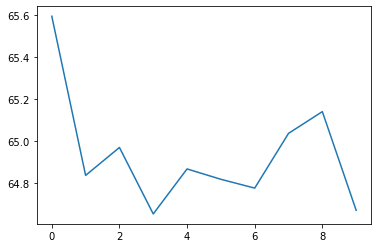

In [132]:
df_time_per_turn.plot()